# Spektren Berechnen
**Date**: october 2015
**Author**: ESR

----
In Dieser Abschnitt wird die Berechnung der Spektren diskutiert.

Die Spektren sind wie folgt berechnet:

1. Mikrophon Signal mit Terzband-Filterbank zerlegen (ab 100Hz, betrachte  Bemerkung über Nahfeldeffekten )
2. output der Filterbank auf einen definierten Intervall integrieren/mitteln (leq/sel)

Für die Abschnitte **Q1** und **Q4**  ist die Vorbeifahrtszeit jedes Drehgestell (sihe [auswertungLS](auswertungLS.ipynb)) bekannt und damit kann man unterschiedliche Integrationsintervalle (z.b: Achsweise) definieren. Damit ist es möglich:

- der Anzahl der Spektren zu erhöhen. 
- den Einfluss der Übersteuerung auf die Spektern , welche am Anfang der Vorbeifahrt entsteht, kann genauer untersucht werden.
 
**Notwendige Modulen**

In [4]:
%reset -f
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%aimport functions
import numpy as np
import copy
import acoustics
from functions import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['lines.linewidth']=0.5
# uncomment next line to connect a qtconsole to the same session
# %qtconsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Intervalle: Aufteilung des Zug definieren

- `full`: gesamte signal
- `n`: Wagenmitte der n-te Wagen bis zur Wagenmitte der n+1 Wagen

Die nächste funktion implementiert die Intervalle aus die Vorbeifahrtszeiten jedes Drehgestell

In [5]:
def defIntervals(tp):
    Intervals = {
                'full': (-np.inf,np.inf)
                #'vorbei': (tp.min(),tp.max()),
                }
    t = tp.reshape(len(tp)//4,4).mean(1)

    for n, (t1,t2) in enumerate(zip(t[:-1],t[1:])):
        Intervals[int(n+1)] = (t1,t2)
    return Intervals

### Integration

Um die Trezbandsignalen auf die Intervalle zu integrieren sind die 2 folgende funktionen im `functions` definiert

In [6]:
%psource cut_third_oct_spectrum
%psource level_from_octBank

## Beispeiel
**Daten und Signale Importieren**

In [7]:
%%capture c
import json
passby = json.load(open('Tabellen\passby.json','r+'))
fill_passby_with_signals(passby)

----
### Auswahl einer Vorbeifahrt und zusammenstellung der Daten 
Folgende Grössen werden zu den für Abschnitte **Q1** und **Q2** hinzugefügt:

1. berecne bandpass and A-gewichtet Signal
2. berechne tPeaks
3. berechne Speeds
4. passby mit Intervalle füllen


In [8]:
passbyID = '5'
pb = copy.deepcopy({k:passby[passbyID][k] for k in ['Q1','Q4']})
#
for k, v in pb.items():
    v['signals']['bandpass'] = v['signals']['MIC'].bandpass(20,20000)
    v['signals']['A'] = v['signals']['MIC'].weigh()
    v['tPeaks'] = detect_weel_times(v['signals']['LS'])
    v.update( {k:v for k,v in zip(['vAv', 'dv', 'ti_vi'], train_speed(v['tPeaks'], axleDistance=2))} )
    # Intervalle
    v['intervals'] = defIntervals(v['tPeaks'])
    

Minimal time interval between maxima is:  0.027 ,which is equvalent to  149  samples
Minimal time interval between maxima is:  0.027 ,which is equvalent to  149  samples


#### Plotten der Mikrophon Signal

<IPython.core.display.Javascript object>


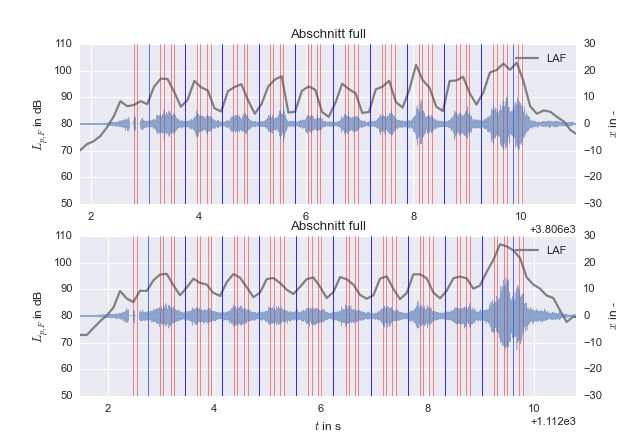

In [11]:
f, ax = plt.subplots(nrows=2,sharey=True)
ax2 = []
for n,(k,v) in enumerate(pb.items()):
    sn = v['signals']
    axis = ax[n]
    ax2.append(axis.twinx())
    ax2[n].grid(False)
    sn['A'].plot(ax = ax2[n], label = 'A', title='', alpha = 0.6, lw = 0.5 )
    sn['A'].plot_levels(ax = axis,color = 'grey', label = 'LAF' ,lw = 2)
    for tb in v['tPeaks']:
        axis.axvline(tb, color = 'red',alpha = 0.8 )
    
    for k,(t1,t2) in v['intervals'].items():
        if isinstance(k,int):
            axis.axvline(t1, color = 'blue', alpha = 1 )
            axis.axvline(t2, color = 'blue', alpha = 1 )
    
    axis.set_xbound(v['tPeaks'].min()-1,v['tPeaks'].max()+1)
    axis.set_title('Abschnitt {}'.format(k))
    axis.legend()
    ax2[n].set_ybound(30,-30)
ax[0].set_xlabel('')
    

**Bemerkung**: Die zeitachse der signale sind nicht sinkronisiert

### Spektren für unterschiedliche Intervalle berechnen

- passby mit  `SEL` Spektren für die definierte intervalle füllen
- passby mit  `leq` Spektren für die definierte intervalle füllen

In [12]:
%%time
Bands = acoustics.signal.OctaveBand(fstart = 100,fstop=20000, fraction=3)
for absch ,v in pb.items():
    # calc Octave
    sn = v['signals']['bandpass']
    f , octFilterBank =  sn.third_octaves(frequencies = Bands.nominal)
    # sel
    spektrum, sel = cut_third_oct_spectrum( octFilterBank, v['intervals'],lType= 'leq')
    v.setdefault('spektrum_sel',{}).update(spektrum)
    v.setdefault('sel',{}).update(sel)
    v['spektrum_sel']['f'] = f.nominal
    # leq
    spektrum, leq = cut_third_oct_spectrum( octFilterBank, v['intervals'], lType= 'leq')
    v['spektrum'].update(spektrum)
    v.setdefault('leq',{}).update(leq)
    v['spektrum']['f'] = f.nominal

Wall time: 2.92 s


### Graphische Darstellung der Spektren für unterschiedlichen Auswertung Intervallen
#### LEQ Spektren und levels

<IPython.core.display.Javascript object>


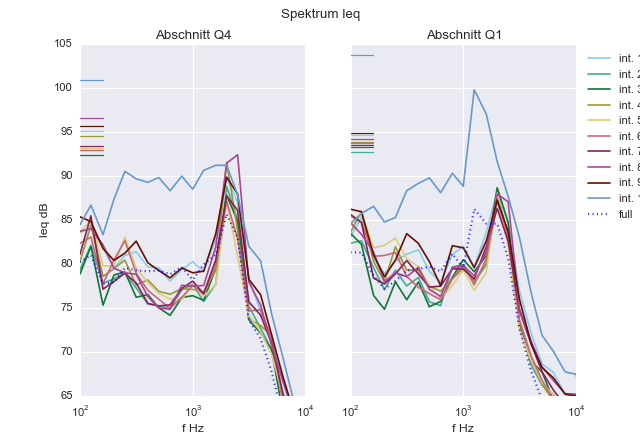

In [13]:
#leq
hexcol = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', 
           '#CC6677', '#882255', '#AA4499', '#661100', '#6699CC', '#AA4466',
           '#4477AA']

f, axes= plt.subplots(ncols = 2, sharey = True)
f.suptitle('Spektrum leq')
for n,(a,v) in enumerate(pb.items()):
    ax = axes[n]
    ax.set_xscale('log')
    spektrum = v['spektrum']
    level = v['leq']
    for name in list(v['intervals'].keys()):
        if name == 'full':
            opt = {'ls':':', 'color':'b','lw' : 2 ,'alpha' : 0.8, 'label': str(name)}
            l, = ax.plot(spektrum['f'], spektrum[name] ,  **opt )
            ax.axhline(y = level[name], xmin = 100 , xmax = 2000, color = l.get_color(), lw= 1.1, alpha = 1 )
        elif type(name)==int: 
            opt= {'ls':'-', 'color' : hexcol[int(name)],'lw' : 1.5,'label': 'int. {}'.format(name)}  
            l, = ax.plot(spektrum['f'], spektrum[name] ,  **opt )
            ax.axhline(y = level[name], xmin = 0 , xmax = 0.1, color = l.get_color(), lw= 1.1, alpha = 1 )
    ax.set_xbound(100,10000)
    ax.set_xlabel('f Hz')
    ax.set_title('Abschnitt {}'.format(a))
axes[0].set_ybound(65,105)
axes[1].legend(loc='upper center', bbox_to_anchor=(1.19, 1),
          ncol=1, fancybox=True, shadow=True)
axes[0].set_ylabel('leq dB')

Bemerkung: 
- Drehgestellpar 10 enthält die Lokomotive , deswegen so höhe Werte!
- Obwohl handelt es sich um den gleiche Zug über beide Abschnitten haben wir eine sher grosse streuung!
- zum Prüfen ob wirklich den gleiche zug ist!